# Entanglement detection

In [1]:
## import necessary packages
import sys
import numpy as np
import matplotlib as mpl
import math

# mpl.rcParams['figure.dpi'] = 400
# mpl.rcParams["figure.figsize"] = [10, 6]
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# print(sys.version)
# print(sys.executable)
# print(np.__version__)
# print(mpl.__version__)

from qutip import *

## Shadow tomography

### full tomography

In [20]:
# Quantum Process Tomography

# qpt(U, op_basis_list)
# qpt_plot(chi, lbls_list, title=None, fig=None, axes=None)

### shadow tomography

### classical shadow

### derandomized tomography

## quantum circuits

### qunatum trace estimation 

#### entanglement spectrum

In [ ]:
# cnot(N=None, control=0, target=1)
# controlled_gate(U, N=2, control=0, target=1, control_value=1)
# csign(N=None, control=0, target=1)
# hadamard_transform(N=1)
# phasegate(theta, N=None, target=0)
# sqrtswap(N=None, targets=[0, 1])
# swap(N=None, targets=[0, 1])
# toffoli(N=None, controls=[0, 1], target=2)

# qft(N=1)

### Generate GHZ states

/Users/jue/opt/anaconda3/lib/python3.8/site-packages/qutip_qip/operations/gates.py:463: UserWarning: Unknown gate cH
  warnings.warn("Unknown gate %s" % name)


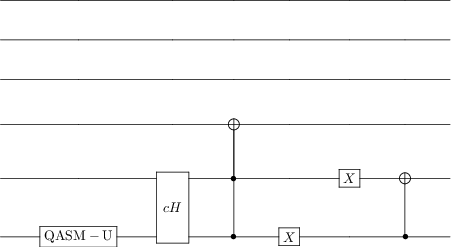

In [21]:
from qutip_qip.circuit import QubitCircuit
from qutip_qip.operations import (Gate, controlled_gate, hadamard_transform)

def controlled_hadamard():
    # Controlled Hadamard
    return controlled_gate(hadamard_transform(1),
                           2,
                           control=0,
                           target=1,
                           control_value=1)

qc = QubitCircuit(N=3, num_cbits=3)
qc.user_gates = {"cH": controlled_hadamard}
qc.add_gate("QASMU", targets=[0], arg_value=[1.91063, 0, 0])
qc.add_gate("cH", targets=[0, 1])
qc.add_gate("TOFFOLI", targets=[2], controls=[0, 1])
qc.add_gate("X", targets=[0])
qc.add_gate("X", targets=[1])
qc.add_gate("CNOT", targets=[1], controls=0)
qc.png


In [30]:
# from qutip import tensor, basis

zero_state = tensor(basis(2, 0), basis(2, 0), basis(2, 0))
result = qc.run(state=zero_state)
wstate = result

print(wstate)

Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
Qobj data =
[[0.        ]
 [0.57734961]
 [0.57734961]
 [0.        ]
 [0.57735159]
 [0.        ]
 [0.        ]
 [0.        ]]


## Entanglement witness

### machine learning ansatz

accuracy of prediction 0: 1.0
accuracy of prediction 1: 1.0


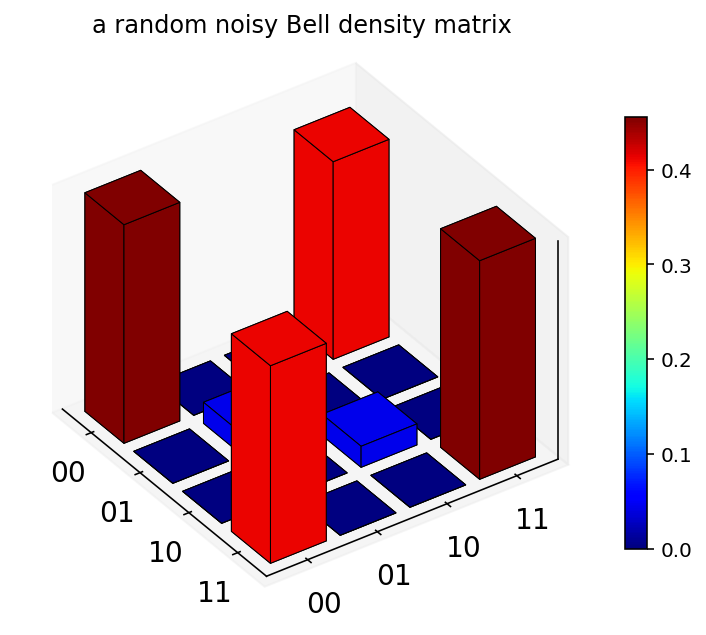

In [348]:
# rand_herm
# rand_unitary
# rand_unitary_haar
# rand_dm(N=3)
# rand_ket

number_samples = 1000
import random

pauli_operators = [qeye(2), sigmax(),sigmay(),sigmaz()]
two_pauli = [tensor([a,b]) for a in pauli_operators for b in pauli_operators ]
# print(two_pauli)

def generate_rand_pure_state_ensemble(d,m):
    return [rand_ket(N=d) for i in range(m)]

def generate_rand_mixed_state_ensemble(d,m):
    return [rand_dm(N=d) for i in range(m)]

def generate_rand_entangled_ensemble(d,m):
    return [rand_dm(N=d) for i in range(m)]

def generate_rand_ghz_ensemble(d,m):
    return [rand_dm(N=d) for i in range(m)]

def generate_two_qubit_product_pure_state(m):
    return [ tensor([rand_ket(N=2),rand_ket(N=2)]) for i in range(m)]

def generate_bell_noisy_density(m,k):
    # p_limit = 1/3
    random_white_noise_p = [random.random()/3 for i in range(m)]

    # density_matrix_bell00 = ket2dm( bell_state(state=k) )
    # print(density_matrix_bell00)

    # noisy_density = density_matrix_bell00* (1 - p) +  p /4 * identity([2,2])
    # print(noisy_density)
    return [
        ket2dm( bell_state(state=k) ) * (1 - p) +  p /4 * identity([2, 2])
        for p in random_white_noise_p
    ]

# generate_rand_pure_state_ensemble(4,5)
def assemble_training_dataset(m):
    bell00_noisy_density = generate_bell_noisy_density(m,'00')
    bell01_noisy_density = generate_bell_noisy_density(m,'01')
    bell10_noisy_density = generate_bell_noisy_density(m,'10')
    bell11_noisy_density = generate_bell_noisy_density(m,'11')
    # generate_two_qubit_product_pure_state(m)
    feature_bell00 = [
        expect(two_pauli, state) for state in bell00_noisy_density
    ]
    feature_bell01 = [
        expect(two_pauli, state) for state in bell01_noisy_density
    ]
    feature_bell10 = [
        expect(two_pauli, state) for state in bell10_noisy_density
    ]
    feature_bell11 = [
        expect(two_pauli, state) for state in bell11_noisy_density
    ]

    # dataset_bell00

    # visualize a random density matrix
    matrix_histogram(bell00_noisy_density[1],
                     xlabels=['00', '01', '10', '11'],
                     ylabels=['00', '01', '10', '11'],
                    #  ylabels=None,
                     title="a random noisy Bell density matrix",
                     limits=None,
                     colorbar=True,
                     fig=None,
                     ax=None,
                     options=None)
    # matrix_histogram_complex(M, xlabels=None, ylabels=None, title=None, limits=None, phase_limits=None, colorbar=True, fig=None, ax=None, threshold=None)

    feature_separable = [
     expect(two_pauli, state)
     for state in generate_two_qubit_product_pure_state(m)
    ]
    feature_separable

    dataset = feature_bell00 + feature_bell01 + feature_bell11 + feature_bell10 + feature_separable

    label = [0 for i in range(m)] + [0 for i in range(m)]+ [0 for i in range(m)]+ [0 for i in range(m)] + [1 for i in range(m)]
    return (dataset, label)

(X, Y) = assemble_training_dataset(number_samples)

################# SVM training ####################

# we create an instance of SVM and fit out data.
# linear kernel
# clf = svm.SVC(kernel='linear')
# # clf = svm.SVC(kernel=my_kernel)
# # # clf.get_params()
# clf.fit(X, Y)
# print(clf.coef0)
# print(clf.coef_)
# print(clf.intercept_)

################# SVM kernel ####################
clf = svm.SVC()
clf.fit(X, Y)

################# test/prediction ####################
prediction_0 = clf.predict([expect(two_pauli, state)
        for state in generate_bell_noisy_density(number_samples,'00')
    ])
prediction_1 = clf.predict([expect(two_pauli, state)
        for state in generate_two_qubit_product_pure_state(number_samples)
    ])
# print(prediction)
print("accuracy of prediction 0:", sum((1-prediction_0))/number_samples)
print("accuracy of prediction 1:", sum(prediction_1)/number_samples)


#### entanglement witness 

In [32]:
# rigorous entanglement witness

# ansatz
w_ansatz = tensor([sigmax(), sigmax(), sigmaz()]) 
print(w_ansatz)

# Bell inequality

# CHSH inequality

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.]]


In [27]:
# plot_expectation_values(results, ylabels=[], title=None, show_legend=False, fig=None, axes=None, figsize=(8, 4))

# plot_wigner_sphere(fig, ax, wigner, reflections)

### Bell, CHSH inequalities

In [ ]:
expect(oper, state)
variance(oper, state)
entropy_relative(rho, sigma, base=2.718281828459045, sparse=False, tol=1e-12)
entropy_vn(rho, base=2.718281828459045, sparse=False)
tracedist(A, B, sparse=False, tol=0)

measure(state, ops, targets=None)
measure_observable(state, op, targets=None)

# covariance_matrix(basis, rho, symmetrized=True)
# logarithmic_negativity(V, g=1.4142135623730951)

#### Two-qubit case

In [331]:
# bell state

# b = Bloch()
# b.show()
# bell_state(state='00')

##### PPT 

$$|\psi \rangle $$

In [334]:
x = basis(3, 2)
M = ket2dm(x)
print(M)
# dag(A)
# ptrace()
# flatten(l)
# partial_transpose(rho, mask, method='dense')

# matrix_histogram(M, xlabels=None, ylabels=None, title=None, limits=None, colorbar=True, fig=None, ax=None)


Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]]


##### Two-qudit

##### Two-qutrit

In [345]:
# qutrit_basis()

#### Three-qubit case

##### bipartite

(<Figure size 432x432 with 1 Axes>,
 <AxesSubplot:xlabel='last particles', ylabel='first particles'>)

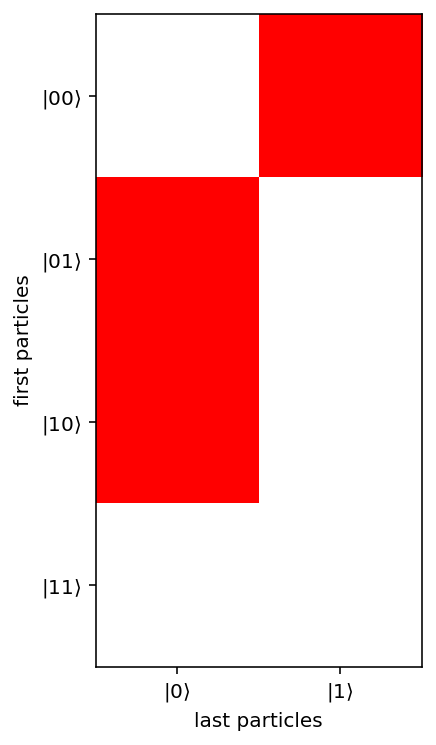

In [346]:
# GHZ
ghz = ghz_state(N=3)

# W
w = w_state(N=3)
# bell_state(state='00')
# singlet_state()

# Schmidt decomposition
plot_schmidt(w, splitting=None, labels_iteration=(3, 2), theme='light', fig=None, ax=None, figsize=(6, 6))

fully separable

biseparable

GME

##### mixed state

Werner state

#### Four-qubit

## version of software package/module 

In [37]:
# about()
# from qutip.ipynbtools import version_table
# version_table()
# qutip.cite()

In [52]:
# conda list

In [333]:
import sklearn
print(sklearn.__version__)

1.1.2


In [29]:
# https://vprusso.github.io/toqito/
from toqito.nonlocal_games.xor_game import XORGame

# The probability matrix.
prob_mat = np.array([[1/4, 1/4], [1/4, 1/4]])

# The predicate matrix.
pred_mat = np.array([[0, 0], [0, 1]])

# Define CHSH game from matrices.
chsh = XORGame(prob_mat, pred_mat)
chsh.classical_value()
chsh.quantum_value()

0.8535533908447781